<a href="https://colab.research.google.com/github/rguimaraesbr/HealthCareAI/blob/main/C%C3%B3pia_de_Analise_de_Dados_pacientes_Cancer_com_4_modelos_e_otimizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#bibliotecas padrao
!pip install keras-tuner --upgrade
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import cv2
import os

config = {
    'ROOT_PATH' : 'breast-histopathology-images',
    'IMG_SIZE' : 200,
    'BATCH_SIZE' : 8
}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.9 MB/s 
     |████████████████████████████████| 1.6 MB 38.0 MB/s 


Montando o drive e descompactando o arquivo do dataset. 

In [3]:
#importar o data set devido ao tamanho o zip e descompactado por seção 
from google.colab import drive
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/Datasets/archive.zip  -d /breast-histopathology-images/> /dev/null


# Excluindo diretorio inutil 
import shutil
shutil.rmtree("/breast-histopathology-images/IDC_regular_ps50_idx5/")

import os

data = os.listdir("/breast-histopathology-images/")
len(data)

Mounted at /content/gdrive


279

Verificando os 10 primeiros

In [4]:
data[:10]

['13666',
 '10272',
 '12881',
 '8974',
 '14156',
 '12906',
 '8914',
 '9324',
 '12884',
 '10301']

Dentro de cada folder existem os folders 0 e 1 - indicando imagens negativas e positivas com relação a IDC

In [5]:
patient_10253 = os.listdir("/breast-histopathology-images/10253")

In [6]:
patient_10253_0 = os.listdir("/breast-histopathology-images/10253/0")
patient_10253_1 = os.listdir("/breast-histopathology-images/10253/1")

print(patient_10253_0[:5])
print(patient_10253_1[:5])

['10253_idx5_x1001_y1301_class0.png', '10253_idx5_x1801_y1301_class0.png', '10253_idx5_x1151_y651_class0.png', '10253_idx5_x2051_y1101_class0.png', '10253_idx5_x1551_y1251_class0.png']
['10253_idx5_x651_y451_class1.png', '10253_idx5_x701_y701_class1.png', '10253_idx5_x851_y301_class1.png', '10253_idx5_x701_y501_class1.png', '10253_idx5_x751_y351_class1.png']


In [7]:
#analisando um folder 
df_0 = pd.DataFrame()

for path in patient_10253_0:
    split = path.split('_')
    # Extraindo as coordenadas atraves do path do arquivo
    x_coord = split[2][1:]
    y_coord = split[3][1:]
    idc_class = 0
    
    data = {"path":"/breast-histopathology-images/10253/0/"+path,
            "x_coord": x_coord,
            "y_coord": y_coord,
            "idc_class": idc_class}
    
    df_0 = df_0.append(data, ignore_index=True)
    
  #verificando as classes   
print(df_0)

df_1 = pd.DataFrame()

for path in patient_10253_1:
    split = path.split('_')
  
    x_coord = split[2][1:]
    y_coord = split[3][1:]
    idc_class = 1
    
    data = {"path":"/breast-histopathology-images/10253/1/"+path,
            "x_coord": x_coord,
            "y_coord": y_coord,
            "idc_class": idc_class}
    
    df_1 = df_1.append(data, ignore_index=True)
    
df = df_0.append(df_1).reset_index(drop=True)
df

                                                  path x_coord y_coord  \
0    /breast-histopathology-images/10253/0/10253_id...    1001    1301   
1    /breast-histopathology-images/10253/0/10253_id...    1801    1301   
2    /breast-histopathology-images/10253/0/10253_id...    1151     651   
3    /breast-histopathology-images/10253/0/10253_id...    2051    1101   
4    /breast-histopathology-images/10253/0/10253_id...    1551    1251   
..                                                 ...     ...     ...   
474  /breast-histopathology-images/10253/0/10253_id...    1651    1001   
475  /breast-histopathology-images/10253/0/10253_id...     901     851   
476  /breast-histopathology-images/10253/0/10253_id...    2151     701   
477  /breast-histopathology-images/10253/0/10253_id...    2151     851   
478  /breast-histopathology-images/10253/0/10253_id...    2051    1051   

     idc_class  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..       

,path,x_coord,y_coord,idc_class
0,/breast-histopathology-images/10253/0/10253_id...,1001,1301,0.0
1,/breast-histopathology-images/10253/0/10253_id...,1801,1301,0.0
2,/breast-histopathology-images/10253/0/10253_id...,1151,651,0.0
3,/breast-histopathology-images/10253/0/10253_id...,2051,1101,0.0
4,/breast-histopathology-images/10253/0/10253_id...,1551,1251,0.0
...,...,...,...,...
544,/breast-histopathology-images/10253/1/10253_id...,601,651,1.0
545,/breast-histopathology-images/10253/1/10253_id...,601,301,1.0
546,/breast-histopathology-images/10253/1/10253_id...,751,251,1.0
547,/breast-histopathology-images/10253/1/10253_id...,601,701,1.0


Vamos preparar um grafico mostrando a composicao de imagens um paciente entre positivo e negativo

In [8]:
df['x_coord'] = df['x_coord'].astype('int')
df['y_coord'] = df['y_coord'].astype('int')

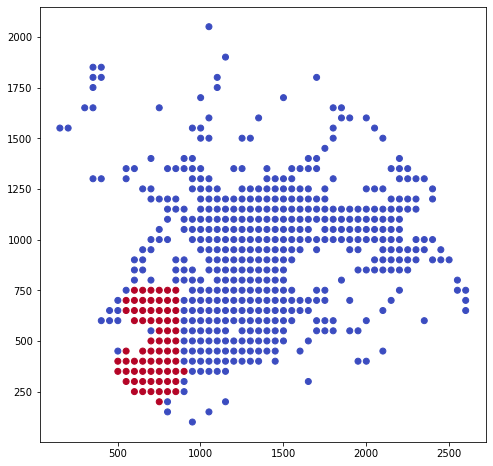

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(x = df['x_coord'], y=df['y_coord'], c=df['idc_class'], cmap='coolwarm')
plt.show()

In [10]:
#obtendo as informacoes de path de todo dataset
from glob import glob
data = glob('/breast-histopathology-images/**/*.png', recursive=True)
print(len(data))


277524


In [11]:
dfs = []
#Criando a meta informacao do dataset
for path in data:
    split = path.split('_')
     #Obtendo os dados do paciente e imagem a partir da informacao do Path
    patient_id = split[0].split('/')[2]
    x_coord = split[2][1:]
    y_coord = split[3][1:]
    idc_class = split[4][-5]
    
    df_data = {"patient_id": patient_id,
              "x_coord": x_coord,
              "y_coord": y_coord,
              "idc_class": idc_class,
               "path": path}
    df = pd.DataFrame()
    dfs.append(df.append(df_data, ignore_index=True))
    
df_all = pd.concat(dfs)

In [12]:
df_all = df_all.reset_index(drop=True)

In [13]:
df_all

,patient_id,x_coord,y_coord,idc_class,path
0,13666,951,1151,1,/breast-histopathology-images/13666/1/13666_id...
1,13666,901,1051,1,/breast-histopathology-images/13666/1/13666_id...
2,13666,1201,601,1,/breast-histopathology-images/13666/1/13666_id...
3,13666,1201,1151,1,/breast-histopathology-images/13666/1/13666_id...
4,13666,951,1201,1,/breast-histopathology-images/13666/1/13666_id...
...,...,...,...,...,...
277519,9382,351,1051,0,/breast-histopathology-images/9382/0/9382_idx5...
277520,9382,1901,651,0,/breast-histopathology-images/9382/0/9382_idx5...
277521,9382,3001,2451,0,/breast-histopathology-images/9382/0/9382_idx5...
277522,9382,351,1901,0,/breast-histopathology-images/9382/0/9382_idx5...


Vamos criar um grafico para ver o numero de positivos e negativos

In [14]:
df_all['x_coord'] = df_all['x_coord'].astype('int')
df_all['y_coord'] = df_all['y_coord'].astype('int')
df_all['idc_class'] = df_all['idc_class'].astype('int')

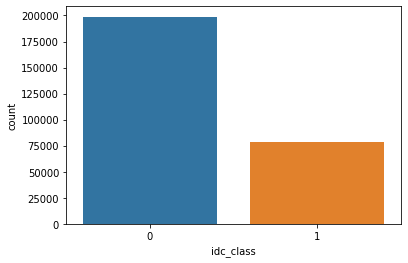

In [15]:

sns.countplot(x='idc_class', data=df_all)

Analisando o numero de imagens (patches) por paciente

In [16]:
df_all['patient_id'].value_counts()

13693    2395
16550    2302
10288    2278
10308    2278
9323     2216
         ... 
16895     151
9175      118
8957      111
9262       94
16534      63
Name: patient_id, Length: 279, dtype: int64

Vamos trabalhar com um subconjunto do dataset original, para agilizar a analise de modelos, apos a conclusão do melhor modelo, vamos aplicar a todo o dataset.

In [ ]:
if not os.path.exists('./hist_images/'):
    print('Criando folders para hist_images')
    os.mkdir('./hist_images/')

    os.mkdir('./hist_images/train/')
    os.mkdir('./hist_images/test/')
    os.mkdir('./hist_images/valid/')

    os.mkdir('./hist_images/train/0/')
    os.mkdir('./hist_images/train/1/')
    os.mkdir('./hist_images/test/0/')
    os.mkdir('./hist_images/test/1/')
    
    os.mkdir('./hist_images/valid/0/')
    os.mkdir('./hist_images/valid/1/')
    
    print('Processando imagens ')
    for batch_num, indices in enumerate(range(1000, len(data), 1000), 1):
        X = []
        y = []

        for i in data[indices-1000:indices]:
            if i.endswith('.png'):
                label=i[-5]
                img = cv2.imread(i)
                if img.shape == (50, 50, 3):
                    X.append(img)
                    y.append(label)


        X = np.array(X)
        y = np.array(y)

        print(f'Processando batch {batch_num}, com imagens de {indices-1000} ate {indices}', end='\r')

        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, stratify=y)

        for index, img in enumerate(X_train):
            idc_class = y_train[index]
            path = os.path.join('hist_images', 'train', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

        for index, img in enumerate(X_test):
            if index%2 == 0:
                idc_class = y_test[index]
                path = os.path.join('hist_images', 'test', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))
            else:
                idc_class = y_test[index]
                path = os.path.join('hist_images', 'valid', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))


Criando folders para hist_images
Processando imagens 


In [ ]:
if not os.path.exists('./hist_images_small/'):
    print('Criando folders para hist_images_small')
    os.mkdir('./hist_images_small/')

    os.mkdir('./hist_images_small/train/')
    os.mkdir('./hist_images_small/test/')
    os.mkdir('./hist_images_small/valid/')

    os.mkdir('./hist_images_small/train/0/')
    os.mkdir('./hist_images_small/train/1/')
    os.mkdir('./hist_images_small/test/0/')
    os.mkdir('./hist_images_small/test/1/')
    
    os.mkdir('./hist_images_small/valid/0/')
    os.mkdir('./hist_images_small/valid/1/')
    
    #Carregando somente 10% dos dados
    print('hist_images_small não  processado, processando agora')
    for batch_num, indices in enumerate(range(1000, int(len(data)/10), 1000), 1):
        X = []
        y = []

        for i in data[indices-1000:indices]:
            if i.endswith('.png'):
                label=i[-5]
                img = cv2.imread(i)
                if img.shape == (50, 50, 3):
                    X.append(img)
                    y.append(label)


        X = np.array(X)
        y = np.array(y)

        print(f'Processando  batch {batch_num}, com imagens de {indices-1000} ate {indices}', end='\r')

        X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.4, stratify=y)

        for index, img in enumerate(X_train):
            idc_class = y_train[index]
            path = os.path.join('hist_images_small', 'train', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
            cv2.imwrite(path, img.astype('int'))

        for index, img in enumerate(X_test):
            if index%2 == 0:
                idc_class = y_test[index]
                path = os.path.join('hist_images_small', 'test', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))
            else:
                idc_class = y_test[index]
                path = os.path.join('hist_images_small', 'valid', str(idc_class), f'batch_{batch_num}_sample_{index}.png')
                cv2.imwrite(path, img.astype('int'))

In [ ]:
#Criando datasets de treino, teste e validação com 10% do total 

In [ ]:
train_paths = glob(os.path.join('hist_images', 'train', '*', '*'), recursive=True)
test_paths = glob(os.path.join('hist_images', 'test', '*', '*'), recursive=True)
valid_paths = glob(os.path.join('hist_images', 'valid', '*', '*'), recursive=True)

train_paths_small = glob(os.path.join('hist_images_small', 'train', '*', '*'), recursive=True)
test_paths_small = glob(os.path.join('hist_images_small', 'test', '*', '*'), recursive=True)
valid_paths_small = glob(os.path.join('hist_images_small', 'valid', '*', '*'), recursive=True)

print(len(train_paths))
print(len(test_paths))
print(len(test_paths))

In [ ]:
print(len(train_paths_small))
print(len(test_paths_small))
print(len(test_paths_small))

In [ ]:
train_paths[:5]

In [ ]:
def get_labels(pathlist):
    labels = []
    for path in pathlist:
        labels.append(int(path.split('/')[2]))
    labels = np.array(labels)
    return labels

train_labels = get_labels(train_paths)
test_labels = get_labels(test_paths)
valid_labels = get_labels(valid_paths)

train_labels_small = get_labels(train_paths_small)
test_labels_small = get_labels(test_paths_small)
valid_labels_small = get_labels(valid_paths_small)

In [ ]:
train_labels[:5]

In [ ]:
def preprocess(image_path, label):  #Utilizando o keras para fazer a transformacao
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, size=[config['IMG_SIZE'], config['IMG_SIZE']])
    img = tf.cast(img, tf.float32)
    
    label = tf.cast(label, tf.float32)

    return img, label

In [ ]:
def create_dataset(images, labels): #Utilizando o keras para criar o dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(len(images)) #shuffle 
    #Vamos passar preprocess em todo dataset
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(config['BATCH_SIZE'], drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_set = create_dataset(train_paths, train_labels)
test_set = create_dataset(test_paths, test_labels)
valid_set = create_dataset(valid_paths, valid_labels)

train_set_small = create_dataset(train_paths_small, train_labels_small) #data set menor para execução 
test_set_small = create_dataset(test_paths_small, test_labels_small)
valid_set_small = create_dataset(valid_paths_small, valid_labels_small)

In [ ]:
for img_batch, label_batch in valid_set_small.take(1):
    fig = plt.figure(figsize=(10,10))
    for i in range(len(img_batch)):
        ax = fig.add_subplot(4,4,i+1)
        ax.imshow(img_batch[i].numpy().astype('int'))
        ax.set_title(label_batch[i].numpy())
plt.tight_layout()

In [ ]:
class_weights = {0:1, 1:3}   #Dado que a base e desbalanceada, decidimos colocar mais peso na classe 1 

Criando a o modelo de CNN afunilando no detalhe dos filtros

In [ ]:
model = keras.models.Sequential([  #Modelo de Rede CNN similar ao dado em aula, e inspirado nos modelos VGG afunilando a extracao de features.   
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomFlip("horizontal"),
    
    keras.layers.Conv2D(32, 3, activation='relu', padding='same',),
    keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.Conv2D(64, 2, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),    
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid') #usamos sigmoid por ser uma classifação binaria
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 200, 200, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                      

Temos uma rede com 5.2 milhoes de parametros treináveis.  Vamos definir parametros de callbacks caso nao melhore com o tempo

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_custom.h5', save_best_only=True)
]

model.compile(loss="binary_crossentropy",  #Usada por ser uma classificaçao binaria
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history = model.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)

Epoch 1/15
2010/2010 [==============================] - 112s 50ms/step - loss: 0.8233 - binary_accuracy: 0.7409 - precision: 0.4960 - recall: 0.7758 - auc: 0.8152 - val_loss: 0.5102 - val_binary_accuracy: 0.8045 - val_precision: 0.8182 - val_recall: 0.3072 - val_auc: 0.8149
Epoch 2/15
2010/2010 [==============================] - 103s 51ms/step - loss: 0.7275 - binary_accuracy: 0.7716 - precision: 0.5355 - recall: 0.8164 - auc: 0.8513 - val_loss: 0.4363 - val_binary_accuracy: 0.7953 - val_precision: 0.5731 - val_recall: 0.8013 - val_auc: 0.8858
Epoch 3/15
2010/2010 [==============================] - 103s 51ms/step - loss: 0.6940 - binary_accuracy: 0.7774 - precision: 0.5432 - recall: 0.8230 - auc: 0.8658 - val_loss: 0.3638 - val_binary_accuracy: 0.8485 - val_precision: 0.7159 - val_recall: 0.6817 - val_auc: 0.8898
Epoch 4/15
2010/2010 [==============================] - 103s 51ms/step - loss: 0.6683 - binary_accuracy: 0.7886 - precision: 0.5590 - recall: 0.8261 - auc: 0.8767 - val_loss: 

Vamos avaliar a matriz de confusão e o relatório de classificação

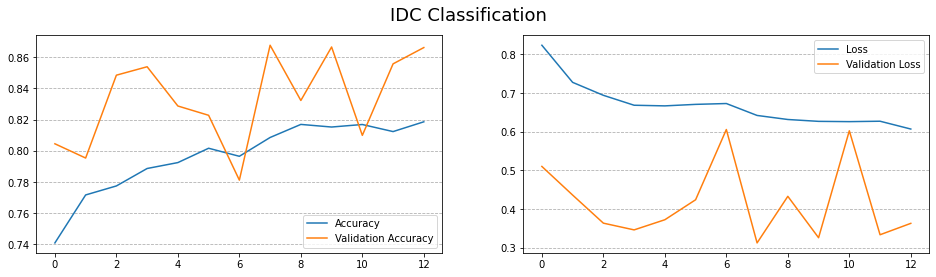

In [ ]:
acc, val_acc = history.history['binary_accuracy'], history.history['val_binary_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('IDC Classification', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

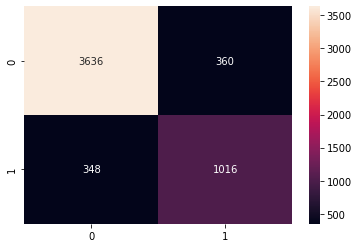

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      3996
         1.0       0.74      0.74      0.74      1364

    accuracy                           0.87      5360
   macro avg       0.83      0.83      0.83      5360
weighted avg       0.87      0.87      0.87      5360



In [ ]:
model3 = keras.models.load_model('breast_cancer_custom.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Avaliando {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model3(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
#Imprimindo a Matriz de Confusão
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()
#Imprimindo o relatorio de classificação
print(sklearn.metrics.classification_report(y_true_small, np.round(y_pred)))

Modelo 2 - EfficientNetV2S 

In [ ]:
model2 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2), #Fazendo data augmentation ja na propria criacao do modelo  (Rotação Randomico)
    keras.layers.RandomZoom(0.15), #Fazendo data augmentation ja na propria criacao do modelo  (Zoom Randomico)
    keras.layers.RandomFlip("horizontal"), ##Fazendo data augmentation ja na propria criacao do modelo  (Flip Randomica)
    keras.applications.EfficientNetV2S(weights='imagenet',include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model2.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnetv2s.h5', save_best_only=True),
]

model2.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history2 = model2.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)


82420632/82420632 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                

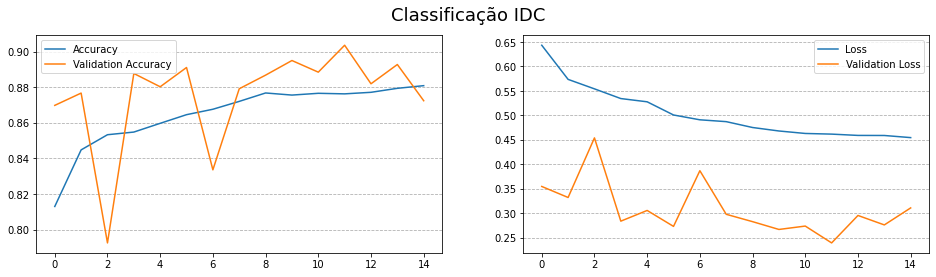

In [ ]:
acc, val_acc = history2.history['binary_accuracy'], history2.history['val_binary_accuracy']
loss, val_loss = history2.history['loss'], history2.history['val_loss']
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Classificação IDC', fontsize=18)

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

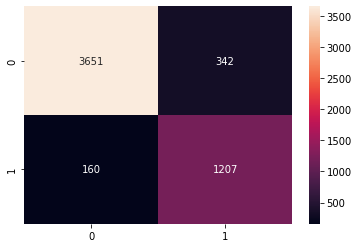

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      3993
         1.0       0.78      0.88      0.83      1367

    accuracy                           0.91      5360
   macro avg       0.87      0.90      0.88      5360
weighted avg       0.91      0.91      0.91      5360



In [ ]:
model2 = keras.models.load_model('breast_cancer_effnetv2s.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model2(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(sklearn.metrics.classification_report(y_true_small, np.round(y_pred)))

In [ ]:
#Modelo 3 -  Resnet 

In [ ]:
model3 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2), #augmentation Random Rotation
    keras.layers.RandomZoom(0.15),  #augmentation Random Zoom
    keras.layers.RandomFlip("horizontal"), #augmentation Random Flip
    keras.applications.ResNet101(weights='imagenet', include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_resnet101.h5',  save_best_only=True)
]

model3.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history3 = model3.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)


171446536/171446536 [==============================] - 9s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 resnet101 (Functional)      (None, None, None, 2048)  42658176  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                     

In [ ]:
model3 = keras.models.load_model('breast_cancer_resnet101.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model3(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(sklearn.metrics.classification_report(y_true_small, np.round(y_pred)))


In [ ]:
#Modelo 4 - Xception

In [ ]:
model4 = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.applications.Xception(weights='imagenet',include_top=False), 
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model4.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_xception.h5',  save_best_only=True)
]

model4.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

history4 = model4.fit(train_set_small,
                     validation_data = valid_set_small,
                     callbacks = callbacks,
                     epochs = 15,
                     class_weight = class_weights)


83683744/83683744 [==============================] - 4s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 200, 200, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 200, 200, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 200, 200, 3)       0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                       

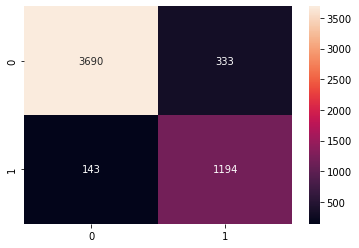

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      4023
         1.0       0.78      0.89      0.83      1337

    accuracy                           0.91      5360
   macro avg       0.87      0.91      0.89      5360
weighted avg       0.92      0.91      0.91      5360



In [ ]:
model4 = keras.models.load_model('breast_cancer_xception.h5')

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model4(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(sklearn.metrics.classification_report(y_true_small, np.round(y_pred)))


In [ ]:
#Vamos avaliar os modelos 

670/670 [==============================] - 23s 32ms/step - loss: 0.2317 - binary_accuracy: 0.9110 - precision_3: 0.7822 - recall_3: 0.8925 - auc_3: 0.9624
              Recall  Precision       AUC
Custom CNN  0.452915   0.793194  0.900777
EffNetV2S   0.861940   0.791638  0.959242
ResNet101   0.696789   0.851277  0.937808
Xception    0.892537   0.782211  0.962446


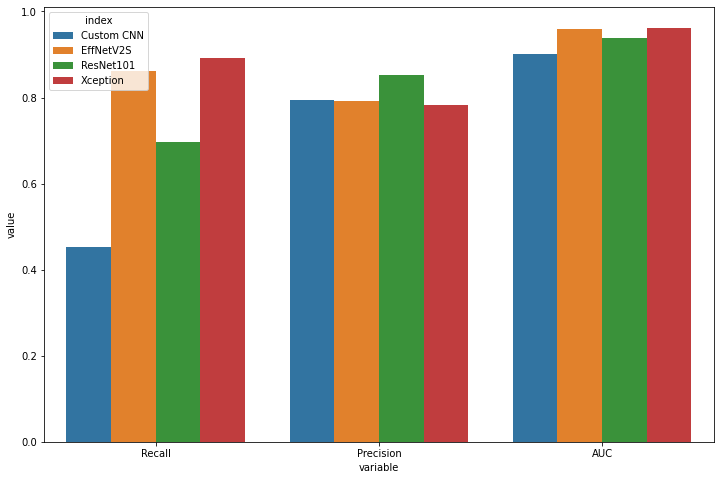

In [ ]:
import seaborn as sns

# Evaluate the models to get performance stats
preds_custom = model.evaluate(test_set_small)
preds_effnet = model2.evaluate(test_set_small)
preds_resnet = model3.evaluate(test_set_small)
preds_xception = model4.evaluate(test_set_small)

# Extract into relevant model-related stats
cnn_recall, cnn_precision, cnn_auc, cnn_params = preds_custom[3], preds_custom[2], preds_custom[4], model.count_params()
effnet_recall, effnet_precision, effnet_auc, effnet_params = preds_effnet[3], preds_effnet[2], preds_effnet[4], model2.count_params()
resnet_recall, resnet_precision, resnet_auc, resnet_params = preds_resnet[3], preds_resnet[2], preds_resnet[4], model3.count_params()
xception_recall, xception_precision, xception_auc, xception_params = preds_xception[3], preds_xception[2], preds_xception[4], model4.count_params()

# Create dict to hold values
data = {
    'Custom CNN' : [cnn_recall, cnn_precision, cnn_auc],
    'EffNetV2S' : [effnet_recall, effnet_precision, effnet_auc],
    'ResNet101' : [resnet_recall, resnet_precision, resnet_auc],
    'Xception' : [xception_recall, xception_precision, xception_auc]
}

# Dict to DF
df = pd.DataFrame(data, index = ["Recall", "Precision", "AUC"]).T

print(df)

fig, ax = plt.subplots(figsize=(12, 8))

df_bar = df.reset_index().melt(id_vars=["index"])
sns.barplot(x="variable", y="value", hue="index", data=df_bar, ax=ax)


Escolhemos para segur adiante o Effnet, devido a ter o melhor recall e AUC equivalente ao Xception, alem exigir menor capacidade de computacao.

Vamos agora obter os melhores hiper paramentros para a rede, utilizando o Keras Tuner. 
 KerasTuner é uma estrutura de otimização de hiperparâmetros escalável e fácil de usar que resolve os pontos problemáticos da pesquisa de hiperparâmetros. Configura facilmente seu espaço de pesquisa com uma sintaxe definida por execução e aproveita um dos algoritmos de pesquisa disponíveis para encontrar os melhores valores de hiperparâmetros para seus modelos. O KerasTuner vem com algoritmos de otimização bayesiana, hyperband e pesquisa aleatória integrados e também foi projetado para ser fácil para os pesquisadores estenderem a fim de experimentar novos algoritmos de pesquisa.

In [29]:
import keras_tuner as kt
#Critando a rede Effnet

def build_effnet(hp):
    model = keras.Sequential()
    keras.layers.InputLayer(input_shape=[config['IMG_SIZE'], config['IMG_SIZE'], 3]),
    keras.layers.RandomRotation(hp.Choice('random_rot', [0.10, 0.15, 0.20, 0.3])),
    keras.layers.RandomZoom(hp.Choice('random_zoom', [0.10, 0.15, 0.20, 0.3])),
    keras.layers.RandomFlip(hp.Choice('Bflip', ['horizontal', 'vertical', 'horizontal_and_vertical'])),
    model.add(keras.applications.EfficientNetV2S(weights='imagenet', include_top=False))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=[
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

    return model

In [30]:
tuner = kt.Hyperband(
    build_effnet,
    objective='val_loss',
    max_epochs=5)



82420632/82420632 [==============================] - 5s 0us/step


In [31]:

tuner.search_space_summary()

Search space summary
Default search space size: 4
random_rot (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.2, 0.3], 'ordered': True}
random_zoom (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.2, 0.3], 'ordered': True}
Bflip (Choice)
{'default': 'horizontal', 'conditions': [], 'values': ['horizontal', 'vertical', 'horizontal_and_vertical'], 'ordered': False}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


In [ ]:
config['BATCH_SIZE'] = 2
train_set_small = create_dataset(train_paths_small, train_labels_small)
test_set_small = create_dataset(test_paths_small, test_labels_small)
valid_set_small = create_dataset(valid_paths_small, valid_labels_small)


In [32]:
tuner.search(train_set_small, 
             epochs=5, 
             validation_data=valid_set_small)


Trial 10 Complete [00h 24m 41s]
val_loss: 0.2402213215827942

Best val_loss So Far: 0.2299761027097702
Total elapsed time: 02h 39m 50s


In [33]:
tuned_model = tuner.get_best_models()[0] #melhor modelo obtido oi

In [34]:
tuned_model.save('breast_cancer_tuned_baseline.h5') #Salvando o modelo tunado 


In [44]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):   #Funçao F1 modificada de acordo com xx
    y_pred = K.cast(K.round(y_pred), 'float32')
    tp = K.sum(K.cast(y_true*y_pred, 'float32'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float32'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float32'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred): #Funçao F1_loss modificada de acordo com xx
    tp = K.sum(K.cast(y_true*y_pred, 'float32'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float32'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float32'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float32'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


In [45]:
config['BATCH_SIZE'] = 8

In [46]:
#ACERTAR AQUI
model_f1_loss = keras.models.load_model('breast_cancer_tuned_baseline.h5')

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnet_f1_loss.h5',  save_best_only=True, monitor="val_f1"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5)
]

model_f1_loss.compile(loss=f1_loss,
              optimizer='adam',
              metrics=[
                  f1,
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

model_f1_loss_history = model_f1_loss.fit(train_set_small,
                     validation_data=valid_set_small,
                     callbacks=callbacks,
                     epochs=15,
                    class_weight=class_weights)


Epoch 1/15
2014/2014 [==============================] - 313s 147ms/step - loss: 0.4863 - f1: 0.6487 - binary_accuracy: 0.8211 - precision_2: 0.6265 - recall_2: 0.7684 - auc_2: 0.8305 - val_loss: 0.3789 - val_f1: 0.6216 - val_binary_accuracy: 0.8039 - val_precision_2: 0.5784 - val_recall_2: 0.8710 - val_auc_2: 0.8592 - lr: 0.0010
Epoch 2/15
2014/2014 [==============================] - 291s 145ms/step - loss: 0.4737 - f1: 0.6571 - binary_accuracy: 0.8272 - precision_2: 0.6372 - recall_2: 0.7751 - auc_2: 0.8327 - val_loss: 0.3452 - val_f1: 0.6553 - val_binary_accuracy: 0.8411 - val_precision_2: 0.6432 - val_recall_2: 0.8558 - val_auc_2: 0.8640 - lr: 0.0010
Epoch 3/15
2014/2014 [==============================] - 290s 144ms/step - loss: 0.5035 - f1: 0.6364 - binary_accuracy: 0.8091 - precision_2: 0.6050 - recall_2: 0.7617 - auc_2: 0.8087 - val_loss: 0.3537 - val_f1: 0.6468 - val_binary_accuracy: 0.8464 - val_precision_2: 0.6661 - val_recall_2: 0.8042 - val_auc_2: 0.8509 - lr: 0.0010
Epoch 4

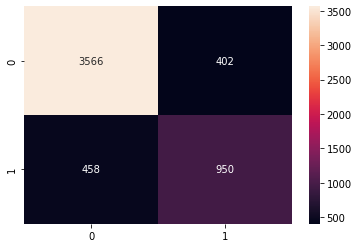

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      3968
         1.0       0.70      0.67      0.69      1408

    accuracy                           0.84      5376
   macro avg       0.79      0.79      0.79      5376
weighted avg       0.84      0.84      0.84      5376



In [47]:
config['BATCH_SIZE'] = 8
model_f1_loss = keras.models.load_model('breast_cancer_effnet_f1_loss.h5', custom_objects={'f1_loss':f1_loss, 'f1':f1})

y_pred = np.array([])
y_true_small = np.array([])
count = 0

for x, y in test_set_small:
    print(f'Evaluating batch {count}/{len(test_set_small)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model_f1_loss(x).numpy().flatten()])
    y_true_small = np.concatenate([y_true_small, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true_small, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(sklearn.metrics.classification_report(y_true_small, np.round(y_pred)))

In [ ]:
model_tuned = keras.models.load_model('breast_cancer_tuned_baseline.h5', custom_objects={'f1':f1})

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnet_tuned.h5',  save_best_only=True, monitor="val_f1"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=5)
]

model_tuned.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[
                  f1,
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

model_tuned_history = model_tuned.fit(train_set,
                     validation_data=valid_set,
                     callbacks=callbacks,
                     epochs=15,
                    class_weight=class_weights)

Epoch 1/15
20593/20593 [==============================] - 2881s 139ms/step - loss: 0.5289 - f1: 0.7190 - binary_accuracy: 0.8508 - precision_4: 0.6868 - recall_4: 0.8792 - auc_4: 0.9301 - val_loss: 0.3328 - val_f1: 0.7291 - val_binary_accuracy: 0.8589 - val_precision_4: 0.6913 - val_recall_4: 0.9161 - val_auc_4: 0.9476 - lr: 0.0100
Epoch 2/15
20593/20593 [==============================] - 2865s 139ms/step - loss: 0.4967 - f1: 0.7307 - binary_accuracy: 0.8602 - precision_4: 0.7020 - recall_4: 0.8885 - auc_4: 0.9381 - val_loss: 0.3714 - val_f1: 0.7152 - val_binary_accuracy: 0.8405 - val_precision_4: 0.6539 - val_recall_4: 0.9410 - val_auc_4: 0.9507 - lr: 0.0100
Epoch 3/15
20593/20593 [==============================] - 2861s 139ms/step - loss: 0.4759 - f1: 0.7329 - binary_accuracy: 0.8649 - precision_4: 0.7094 - recall_4: 0.8938 - auc_4: 0.9430 - val_loss: 0.3720 - val_f1: 0.7245 - val_binary_accuracy: 0.8467 - val_precision_4: 0.6642 - val_recall_4: 0.9395 - val_auc_4: 0.9529 - lr: 0.010

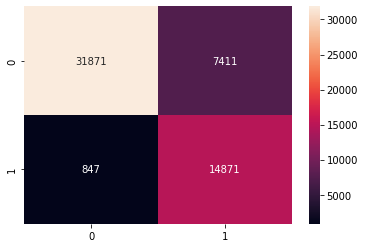

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.89     39282
         1.0       0.67      0.95      0.78     15718

    accuracy                           0.85     55000
   macro avg       0.82      0.88      0.83     55000
weighted avg       0.89      0.85      0.86     55000



In [49]:
model_tuned = keras.models.load_model('breast_cancer_effnet_tuned.h5', custom_objects={'f1':f1})

y_pred = np.array([])
y_true = np.array([])
count = 0

for x, y in test_set:
    print(f'Evaluating batch {count}/{len(test_set)}', end='\r')
    count += 1
    y_pred = np.concatenate([y_pred, model_tuned(x).numpy().flatten()])
    y_true = np.concatenate([y_true, y.numpy()])
    
sns.heatmap(confusion_matrix(y_true, np.round(y_pred)), annot=True, fmt='g')
plt.show()

print(sklearn.metrics.classification_report(y_true, np.round(y_pred)))